<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo_127/blob/main/Ana%CC%81lisis_Agua_Reto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Reto 1
#Limpieza, análisis, visualización y kmeans
#Ciencia de datos
#Equipo 127
#Javier de Alba Perez
#Gustavo Guerrero Villa
#16/11/2022

In [ ]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import math
import matplotlib.pyplot as plt
import requests, zipfile
from io import BytesIO
import sklearn

from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import geopandas as gpd
from shapely.geometry import Point

In [ ]:
#Importar la tabla y asignarla a df_sub como un dataframe de pandas
url = 'http://201.116.60.46/Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'
req = requests.get(url)
zipfile.ZipFile(BytesIO(req.content)).extractall('unzipped_zip/')
df_sub=pd.read_csv('unzipped_zip/Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv', encoding = 'latin1')
df_sub.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


In [ ]:
#Generar los estadísticos principales de la tabla
df_aguas = df_sub.copy()
df_aguas.describe()

,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CONDUCT_mS/cm,SDT_mg/L
count,1068.000000,1068.000000,1068.0,1064.000000,1062.000000,0.0
mean,-101.891007,23.163618,2020.0,235.633759,1138.953013,NaN
std,6.703263,3.887670,0.0,116.874291,1245.563674,NaN
min,-116.664250,14.561150,2020.0,26.640000,50.400000,NaN
25%,-105.388865,20.212055,2020.0,164.000000,501.750000,NaN
50%,-102.174180,22.617190,2020.0,215.527500,815.000000,NaN
75%,-98.974716,25.510285,2020.0,292.710000,1322.750000,NaN
max,-86.864120,32.677713,2020.0,1650.000000,18577.000000,NaN


In [ ]:
#Identificar los dtype de las variables de la tabla
df_aguas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

In [ ]:
#Validar que las columnas estén indexadas para su análisis correcto
df_aguas.columns

Index(['CLAVE', 'SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO',
       'ACUIFERO', 'SUBTIPO', 'LONGITUD', 'LATITUD', 'PERIODO', 'ALC_mg/L',
       'CALIDAD_ALC', 'CONDUCT_mS/cm', 'CALIDAD_CONDUC', 'SDT_mg/L',
       'SDT_M_mg/L', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'FLUORUROS_mg/L',
       'CALIDAD_FLUO', 'DUR_mg/L', 'CALIDAD_DUR', 'COLI_FEC_NMP/100_mL',
       'CALIDAD_COLI_FEC', 'N_NO3_mg/L', 'CALIDAD_N_NO3', 'AS_TOT_mg/L',
       'CALIDAD_AS', 'CD_TOT_mg/L', 'CALIDAD_CD', 'CR_TOT_mg/L', 'CALIDAD_CR',
       'HG_TOT_mg/L', 'CALIDAD_HG', 'PB_TOT_mg/L', 'CALIDAD_PB', 'MN_TOT_mg/L',
       'CALIDAD_MN', 'FE_TOT_mg/L', 'CALIDAD_FE', 'SEMAFORO', 'CONTAMINANTES',
       'CUMPLE_CON_ALC', 'CUMPLE_CON_COND', 'CUMPLE_CON_SDT_ra',
       'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO', 'CUMPLE_CON_DUR',
       'CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS', 'CUMPLE_CON_CD',
       'CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB', 'CUMPLE_CON_MN',
       'CUMPLE_CON_FE'],
      dtype='

In [ ]:
#Conteo de NAs
df_aguas.isna().sum().sort_values(ascending=False)

SDT_mg/L                1068
CONTAMINANTES            434
CALIDAD_CONDUC             6
CONDUCT_mS/cm              6
ALC_mg/L                   4
CALIDAD_ALC                4
CALIDAD_SDT_ra             2
SDT_M_mg/L                 2
CALIDAD_SDT_salin          2
CALIDAD_N_NO3              1
CALIDAD_DUR                1
N_NO3_mg/L                 1
DUR_mg/L                   1
CUMPLE_CON_COND            0
CUMPLE_CON_ALC             0
SEMAFORO                   0
CALIDAD_FE                 0
FE_TOT_mg/L                0
CALIDAD_MN                 0
CUMPLE_CON_SDT_ra          0
CUMPLE_CON_SDT_salin       0
CLAVE                      0
CUMPLE_CON_FLUO            0
CUMPLE_CON_DUR             0
CALIDAD_PB                 0
CUMPLE_CON_CF              0
CUMPLE_CON_NO3             0
CUMPLE_CON_AS              0
CUMPLE_CON_CD              0
CUMPLE_CON_CR              0
CUMPLE_CON_HG              0
CUMPLE_CON_PB              0
CUMPLE_CON_MN              0
MN_TOT_mg/L                0
CD_TOT_mg/L   

In [ ]:
#columnas_categorias =

columnas_numericas = ['ALC_mg/L','CONDUCT_mS/cm','SDT_mg/L','SDT_M_mg/L','FLUORUROS_mg/L','DUR_mg/L','COLI_FEC_NMP/100_mL',
                      'N_NO3_mg/L','AS_TOT_mg/L','CD_TOT_mg/L','CR_TOT_mg/L','HG_TOT_mg/L','PB_TOT_mg/L','MN_TOT_mg/L','FE_TOT_mg/L']

df_clean = df_aguas[['ALC_mg/L','CONDUCT_mS/cm','SDT_mg/L','SDT_M_mg/L','FLUORUROS_mg/L','DUR_mg/L','COLI_FEC_NMP/100_mL',
                      'N_NO3_mg/L','AS_TOT_mg/L','CD_TOT_mg/L','CR_TOT_mg/L','HG_TOT_mg/L','PB_TOT_mg/L','MN_TOT_mg/L','FE_TOT_mg/L']]

#Ahora que gano la imputacion pues vamos a analizar como se va  a hacer ahorita en un siguiente renglon
df_clean

,ALC_mg/L,CONDUCT_mS/cm,SDT_mg/L,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,229.990,940.0,NaN,603.6,0.9766,213.732,<1.1,4.184656,0.0161,<0.003,<0.005,<0.0005,<0.005,<0.0015,0.0891
1,231.990,608.0,NaN,445.4,0.9298,185.0514,<1.1,5.75011,0.0134,<0.003,<0.005,<0.0005,<0.005,<0.0015,<0.025
2,204.920,532.0,NaN,342,1.8045,120.719,<1.1,1.449803,0.037,<0.003,<0.005,<0.0005,<0.005,<0.0015,<0.025
3,327.000,686.0,NaN,478.6,1.1229,199.879,<1.1,1.258597,0.0154,<0.003,0.005,<0.0005,<0.005,<0.0015,<0.025
4,309.885,1841.0,NaN,1179,0.2343,476.9872,291,15.672251,<0.01,<0.003,<0.005,<0.0005,<0.005,<0.0015,<0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,231.045,2350.0,NaN,1545.8,<0.2,752.096,<1.1,14.615488,<0.01,<0.003,<0.005,<0.0005,<0.005,<0.0015,<0.025
1064,256.000,529.0,NaN,297,<0.2,273,<1.1,77.392,<0.01,<0.003,<0.005,<0.0005,<0.005,0.00709,0.07578
1065,330.690,2600.0,NaN,1873,0.7574,660.2126,620,36.477104,<0.01,<0.003,<0.005,<0.0005,<0.005,0.0242,0.2129
1066,193.140,873.0,NaN,690.6667,0.7108,406.368,<1.1,<0.02,<0.01,<0.003,<0.005,<0.0005,<0.005,0.012,0.1786


<class 'pandas.core.frame.DataFrame'>


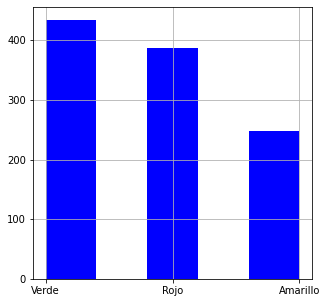

In [ ]:
y= pd.DataFrame(df_aguas['SEMAFORO'])
y
print(type(y))
y['SEMAFORO'].hist(bins = 5, figsize=(5,5), color = 'blue')

In [ ]:
#Quitaremos los caracteres '<'
columnas_numericas = ['ALC_mg/L','CONDUCT_mS/cm','SDT_mg/L','SDT_M_mg/L','FLUORUROS_mg/L','DUR_mg/L','COLI_FEC_NMP/100_mL',
                      'N_NO3_mg/L','AS_TOT_mg/L','CD_TOT_mg/L','CR_TOT_mg/L','HG_TOT_mg/L','PB_TOT_mg/L','MN_TOT_mg/L','FE_TOT_mg/L']

for name in columnas_numericas:
  df_clean[name] = df_clean[name].astype('str')
  df_clean[name] = df_clean[name].str.replace('<','')  
  df_clean[name]= df_clean[name].astype('float')

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ALC_mg/L             1064 non-null   float64
 1   CONDUCT_mS/cm        1062 non-null   float64
 2   SDT_mg/L             0 non-null      float64
 3   SDT_M_mg/L           1066 non-null   float64
 4   FLUORUROS_mg/L       1068 non-null   float64
 5   DUR_mg/L             1067 non-null   float64
 6   COLI_FEC_NMP/100_mL  1068 non-null   float64
 7   N_NO3_mg/L           1067 non-null   float64
 8   AS_TOT_mg/L          1068 non-null   float64
 9   CD_TOT_mg/L          1068 non-null   float64
 10  CR_TOT_mg/L          1068 non-null   float64
 11  HG_TOT_mg/L          1068 non-null   float64
 12  PB_TOT_mg/L          1068 non-null   float64
 13  MN_TOT_mg/L          1068 non-null   float64
 14  FE_TOT_mg/L          1068 non-null   float64
dtypes: float64(15)
memory usage: 125.3 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
#Preparamos nuestro pipeline para imputar y rescalar
num_transformer = Pipeline(steps= [('SI', SimpleImputer(strategy='most_frequent')),('MS', MinMaxScaler(feature_range=(1,2)))])

In [ ]:
#Ejecutar función de transformación previamente generada
preprocessor = ColumnTransformer(transformers= [('numerical', num_transformer, columnas_numericas),
                                                ],remainder='passthrough')

preprocessor_fit = preprocessor.fit(df_clean)

In [ ]:
#Soltamos la columna vacía
df_clean.drop('SDT_mg/L', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
columnas_numericas = ['ALC_mg/L','CONDUCT_mS/cm','SDT_M_mg/L','FLUORUROS_mg/L','DUR_mg/L','COLI_FEC_NMP/100_mL',
                      'N_NO3_mg/L','AS_TOT_mg/L','CD_TOT_mg/L','CR_TOT_mg/L','HG_TOT_mg/L','PB_TOT_mg/L','MN_TOT_mg/L','FE_TOT_mg/L']

preprocessor = ColumnTransformer(transformers= [('numerical', num_transformer, columnas_numericas),
                                                ],remainder='passthrough')

preprocessor_fit = preprocessor.fit(df_clean)

In [ ]:
print(df_clean.columns)
print(df_clean.info())
print(df_clean.isnull().sum())

Index(['ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L',
       'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CD_TOT_mg/L',
       'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L',
       'FE_TOT_mg/L'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ALC_mg/L             1064 non-null   float64
 1   CONDUCT_mS/cm        1062 non-null   float64
 2   SDT_M_mg/L           1066 non-null   float64
 3   FLUORUROS_mg/L       1068 non-null   float64
 4   DUR_mg/L             1067 non-null   float64
 5   COLI_FEC_NMP/100_mL  1068 non-null   float64
 6   N_NO3_mg/L           1067 non-null   float64
 7   AS_TOT_mg/L          1068 non-null   float64
 8   CD_TOT_mg/L          1068 non-null   float64
 9   CR_TOT_mg/L          1068 non-null   float64
 10  HG_TOT_mg/L          1

In [ ]:
#Usamos el .T para hacer la transposición
print(df_clean.describe())
df_clean.describe().T

          ALC_mg/L  CONDUCT_mS/cm    SDT_M_mg/L  FLUORUROS_mg/L     DUR_mg/L  \
count  1064.000000    1062.000000   1066.000000     1068.000000  1067.000000   
mean    235.633759    1138.953013    896.101567        1.075600   347.938073   
std     116.874291    1245.563674   2751.530590        1.924278   359.669452   
min      26.640000      50.400000     25.000000        0.200000    20.000000   
25%     164.000000     501.750000    337.500000        0.267175   121.194800   
50%     215.527500     815.000000    550.400000        0.503500   245.335800   
75%     292.710000    1322.750000    916.100000        1.139850   453.930000   
max    1650.000000   18577.000000  82170.000000       34.803300  3810.692200   

       COLI_FEC_NMP/100_mL   N_NO3_mg/L  AS_TOT_mg/L  CD_TOT_mg/L  \
count          1068.000000  1067.000000  1068.000000  1068.000000   
mean            355.490356     4.319759     0.019618     0.003030   
std            2052.457014     8.345134     0.035209     0.000894   
min

,count,mean,std,min,25%,50%,75%,max
ALC_mg/L,1064.0,235.633759,116.874291,26.6400,164.000000,215.527500,292.710000,1650.000000
CONDUCT_mS/cm,1062.0,1138.953013,1245.563674,50.4000,501.750000,815.000000,1322.750000,18577.000000
SDT_M_mg/L,1066.0,896.101567,2751.530590,25.0000,337.500000,550.400000,916.100000,82170.000000
FLUORUROS_mg/L,1068.0,1.075600,1.924278,0.2000,0.267175,0.503500,1.139850,34.803300
DUR_mg/L,1067.0,347.938073,359.669452,20.0000,121.194800,245.335800,453.930000,3810.692200
COLI_FEC_NMP/100_mL,1068.0,355.490356,2052.457014,1.1000,1.100000,1.100000,13.250000,24196.000000
N_NO3_mg/L,1067.0,4.319759,8.345134,0.0200,0.650294,2.080932,5.201698,121.007813
AS_TOT_mg/L,1068.0,0.019618,0.035209,0.0100,0.010000,0.010000,0.010000,0.452200
CD_TOT_mg/L,1068.0,0.003030,0.000894,0.0030,0.003000,0.003000,0.003000,0.032110
CR_TOT_mg/L,1068.0,0.013276,0.154391,0.0050,0.005000,0.005000,0.005000,5.003200


In [ ]:
#Generamos la matriz de correlación
df_clean.corr()

,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
ALC_mg/L,1.000000,0.232003,0.079350,0.069056,0.243177,-0.016449,-0.000394,0.073299,0.032686,-0.014282,0.067195,0.015064,0.129866,0.043423
CONDUCT_mS/cm,0.232003,1.000000,0.286555,-0.025200,0.693146,0.017808,0.219512,-0.003722,0.029040,0.004412,0.059093,0.024083,0.095955,0.083181
SDT_M_mg/L,0.079350,0.286555,1.000000,-0.013798,0.347205,-0.001133,0.101706,-0.010157,0.010800,-0.000682,0.015114,-0.005552,0.018927,0.020104
FLUORUROS_mg/L,0.069056,-0.025200,-0.013798,1.000000,-0.149691,0.003564,-0.019782,0.444079,-0.015123,-0.005242,-0.026358,-0.032236,-0.049742,-0.009994
DUR_mg/L,0.243177,0.693146,0.347205,-0.149691,1.000000,0.031727,0.301468,-0.106498,0.025002,0.007438,0.064839,-0.018908,0.083822,0.059775
COLI_FEC_NMP/100_mL,-0.016449,0.017808,-0.001133,0.003564,0.031727,1.000000,-0.000969,0.038151,-0.001656,-0.008840,-0.007661,0.022510,-0.005326,0.003045
N_NO3_mg/L,-0.000394,0.219512,0.101706,-0.019782,0.301468,-0.000969,1.000000,-0.008019,-0.009362,-0.015131,0.014912,-0.016529,-0.036854,0.013298
AS_TOT_mg/L,0.073299,-0.003722,-0.010157,0.444079,-0.106498,0.038151,-0.008019,1.000000,-0.009078,-0.009582,-0.009939,-0.023057,0.016916,0.014295
CD_TOT_mg/L,0.032686,0.029040,0.010800,-0.015123,0.025002,-0.001656,-0.009362,-0.009078,1.000000,-0.001781,-0.004083,-0.002875,-0.004205,-0.001036
CR_TOT_mg/L,-0.014282,0.004412,-0.000682,-0.005242,0.007438,-0.008840,-0.015131,-0.009582,-0.001781,1.000000,0.005866,-0.001895,-0.005087,0.000629


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


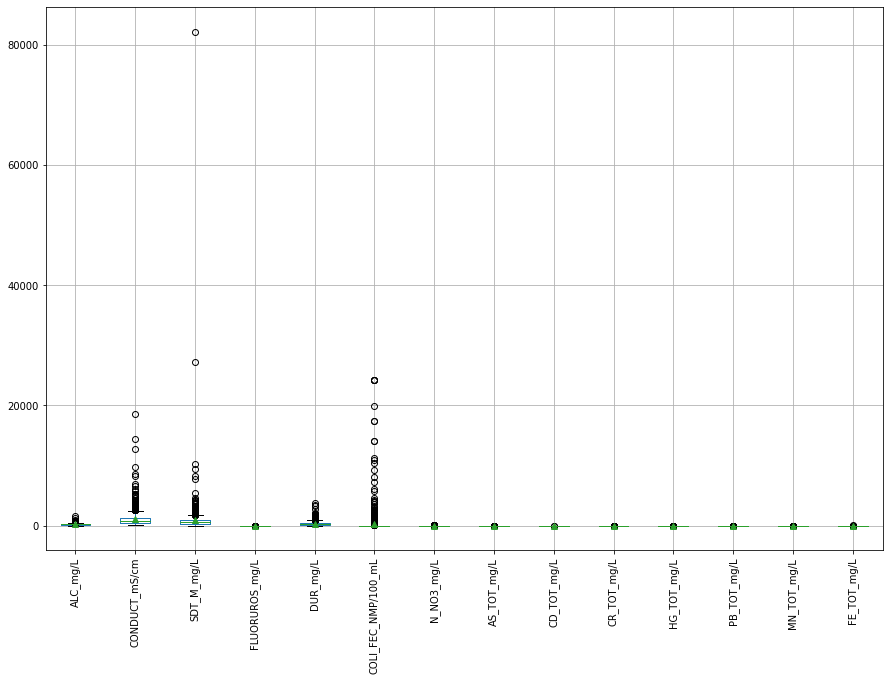

In [ ]:
#Generamos un diagrama de caja para observar outliers

outliers = df_clean.boxplot(figsize = (15,10),showmeans = True)
outliers.plot()
plt.xticks(rotation=90)
plt.show()

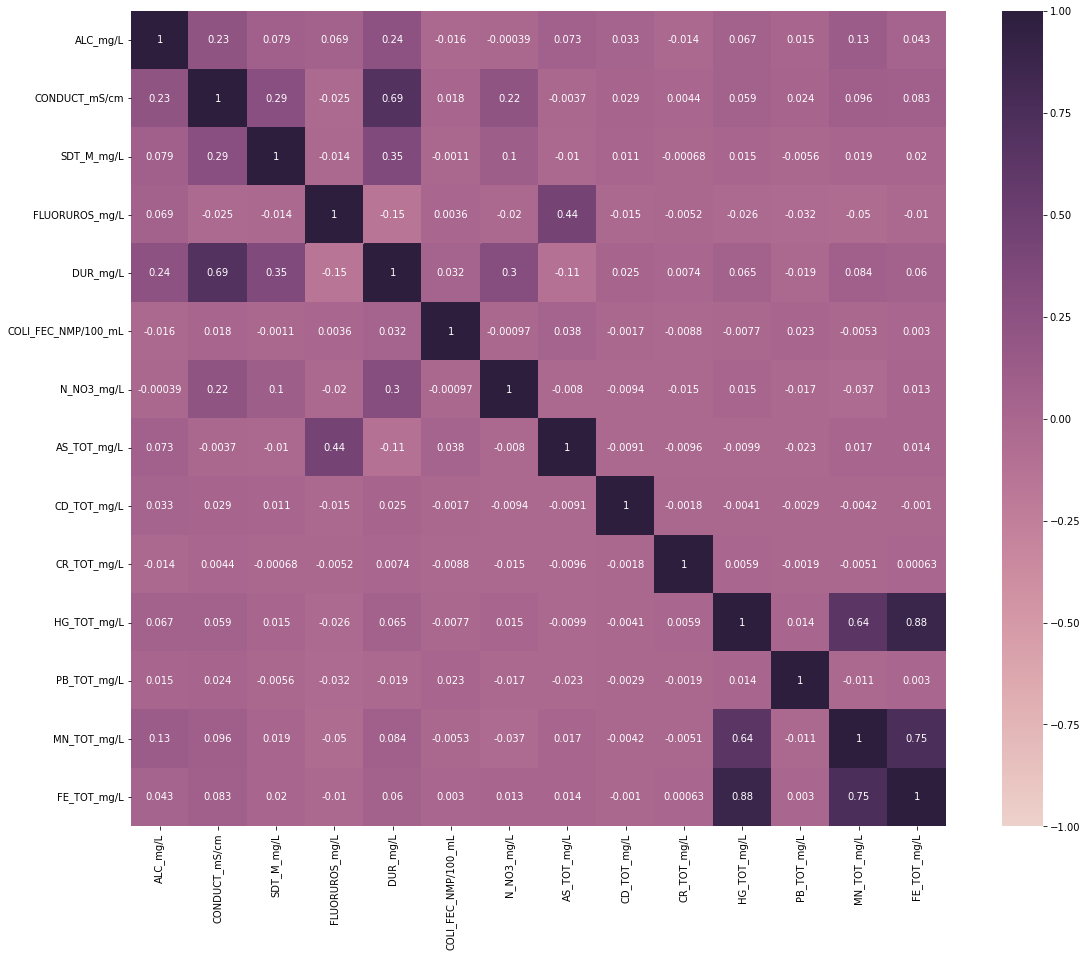

In [ ]:
#generamos la gráfica de correlación

correlacion = df_clean.corr()
f, ax = plt.subplots(figsize = (20,15))
sns.heatmap(correlacion, vmax = 1, vmin = -1, square = True, annot = True, cmap=sns.cubehelix_palette(as_cmap=True))

In [ ]:
#Definir variables de calidad de agua y asignamos coordenadas
df_ubicacion = df_aguas[['LONGITUD','LATITUD']]
df_ubicacion["COORDENADAS"] = list(zip(df_ubicacion.LONGITUD, df_ubicacion.LATITUD))
df_ubicacion["COORDENADAS"] = df_ubicacion["COORDENADAS"].apply(Point)
df_ubicacion.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,LONGITUD,LATITUD,COORDENADAS
0,-102.02210,22.20887,POINT (-102.0221 22.20887)
1,-102.20075,21.99958,POINT (-102.20075 21.99958)
2,-102.28801,22.36685,POINT (-102.28801 22.36685)
3,-102.29449,22.18435,POINT (-102.29449 22.18435)
4,-110.24480,23.45138,POINT (-110.2448 23.45138)


,LONGITUD,LATITUD,COORDENADAS
0,-102.02210,22.20887,POINT (-102.02210 22.20887)
1,-102.20075,21.99958,POINT (-102.20075 21.99958)
2,-102.28801,22.36685,POINT (-102.28801 22.36685)
3,-102.29449,22.18435,POINT (-102.29449 22.18435)
4,-110.24480,23.45138,POINT (-110.24480 23.45138)
...,...,...,...
1063,-99.54191,24.76036,POINT (-99.54191 24.76036)
1064,-99.70099,24.78280,POINT (-99.70099 24.78280)
1065,-99.82249,25.55197,POINT (-99.82249 25.55197)
1066,-100.32683,24.80118,POINT (-100.32683 24.80118)


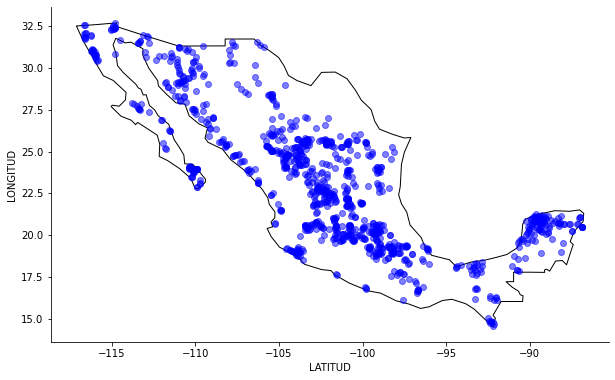

In [ ]:
#Generamos puntos para mapear
puntos_en_mapa = gpd.GeoDataFrame(df_ubicacion, geometry="COORDENADAS")

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

world = world.set_index("iso_a3")
world.name.unique()
fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'Mexico'").plot(ax=gax, edgecolor='black',color='white')

gax.set_xlabel('LATITUD')
gax.set_ylabel('LONGITUD')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

puntos_en_mapa.plot(ax=gax, color='blue', alpha = 0.5)
puntos_en_mapa

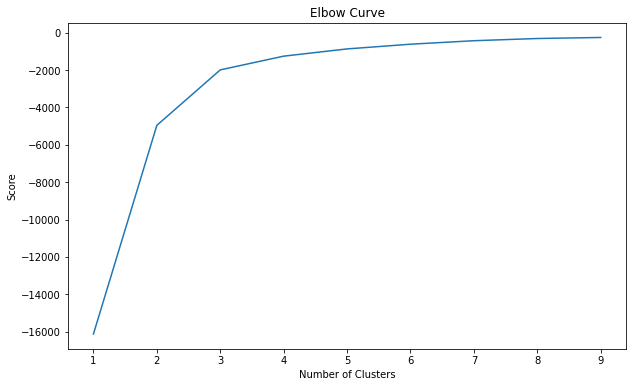

In [ ]:
#Generaremos nuestro Kmeans

from sklearn.cluster import KMeans

clusters = range(1,10) 
mi_kmeans = [KMeans(n_clusters=i) for i in clusters]
Y_axis = df_ubicacion[['LATITUD']]
X_axis = df_ubicacion[['LONGITUD']]
calulo_kmeans = [mi_kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(mi_kmeans))]


plt.figure(figsize=(10,6))
plt.plot(clusters, calulo_kmeans)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [ ]:
#Apalancaremos 3 segmentos de acuerdo a nuestra gráfica de codo
X = df_sub[['LONGITUD', 'LATITUD']]

kmeans = KMeans(n_clusters=3).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X) 
C = kmeans.cluster_centers_ 

C_DF = pd.DataFrame(C) 
C_DF["Coordinates"] = list(zip(C_DF[0], C_DF[1])) 
C_DF["Coordinates"] = C_DF["Coordinates"].apply(Point) 

puntos_centroides = gpd.GeoDataFrame(C_DF, geometry="Coordinates")
puntos_centroides

,0,1,Coordinates
0,-101.722127,22.254226,POINT (-101.72213 22.25423)
1,-110.794488,28.438202,POINT (-110.79449 28.43820)
2,-90.728470,19.473362,POINT (-90.72847 19.47336)


In [ ]:
#imrpmimos los numeros de elementos por cluster
df_sub['SEMAFORO'].value_counts()

Verde       434
Rojo        387
Amarillo    247
Name: SEMAFORO, dtype: int64

In [ ]:
print(y.head())
print(df_ubicacion.head())

  SEMAFORO
0    Verde
1    Verde
2     Rojo
3    Verde
4     Rojo
    LONGITUD   LATITUD                  COORDENADAS
0 -102.02210  22.20887  POINT (-102.02210 22.20887)
1 -102.20075  21.99958  POINT (-102.20075 21.99958)
2 -102.28801  22.36685  POINT (-102.28801 22.36685)
3 -102.29449  22.18435  POINT (-102.29449 22.18435)
4 -110.24480  23.45138  POINT (-110.24480 23.45138)


In [ ]:
y['trafficlight'] = y['SEMAFORO'].replace(to_replace = "Verde", value = "green")
y['trafficlight'].replace(to_replace = "Rojo", value = "red", inplace=True)
y['trafficlight'].replace(to_replace = "Amarillo", value = "yellow", inplace=True)
y

,SEMAFORO,trafficlight
0,Verde,green
1,Verde,green
2,Rojo,red
3,Verde,green
4,Rojo,red
...,...,...
1063,Rojo,red
1064,Rojo,red
1065,Rojo,red
1066,Verde,green


In [ ]:
puntos_en_mapa['LATITUDYLONGITUD'] = puntos_en_mapa['LATITUD'] + puntos_en_mapa['LONGITUD']
diccionario_semaforo = dict(zip(puntos_en_mapa.LATITUDYLONGITUD, y.trafficlight))
diccionario_semaforo

import folium

colors = ['red', 'green', 'blue']
lat = puntos_en_mapa.iloc[0]['LATITUD']
lng = puntos_en_mapa.iloc[0]['LONGITUD']
map = folium.Map(location=[lng, lat], zoom_start=1)
for _, row in puntos_en_mapa.iterrows():
    folium.CircleMarker(
        location=[row["LATITUD"], row["LONGITUD"]],
        radius=12, 
        weight=2, 
        fill=True, 
        fill_color=diccionario_semaforo[row["LATITUDYLONGITUD"]],
        color=diccionario_semaforo[row["LATITUDYLONGITUD"]]
    ).add_to(map)
color='black'
for _, row in puntos_en_mapa.iterrows():
    folium.CircleMarker(
        location=[row[1], row[0]],
        radius=12, 
        weight=2, 
        fill=True, 
        fill_color=color,
        color=color
    ).add_to(map)
map


In [ ]:

DataFrame_Final = pd.concat([df_ubicacion, y], ignore_index=True)
DataFrame_Final['COLOR'] = y['SEMAFORO']
DataFrame_Final.head()

'''
for i in y:
  y.codigo_color[i] = y[i].str.replace('Verde','1') 
  y[i] = y[i].str.replace('Amarillo','2') 
  y[i] = y[i].str.replace('Rojo','3') '''

"\nfor i in y:\n  y.codigo_color[i] = y[i].str.replace('Verde','1') \n  y[i] = y[i].str.replace('Amarillo','2') \n  y[i] = y[i].str.replace('Rojo','3') "

In [ ]:
df_aguas['CALIDAD_COLI_FEC'].value_counts()

Potable - Excelente        739
Buena calidad              208
Aceptable                   60
Contaminada                 49
Fuertemente contaminada     12
Name: CALIDAD_COLI_FEC, dtype: int64

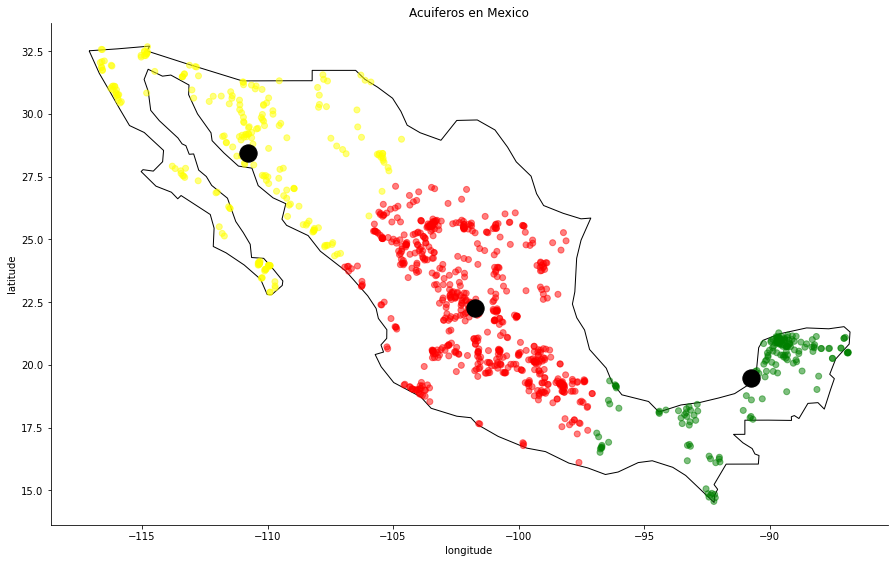

In [ ]:
#Generamos un último mapa mostrando nuestros 3 segmentos
import folium
fig, gax = plt.subplots(figsize=(15,10))
colores = ['red','yellow','green']
color_asig = []

for row in labels:
  color_asig.append(colores[row])

world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white') #filtramos por pais

puntos_en_mapa.plot(ax=gax, color=color_asig, alpha = 0.5) 
puntos_centroides.plot(ax=gax, color='black', alpha = 1, markersize = 300) 

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Acuiferos en Mexico')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

#Parte 2: Clasifiación-ensambles

In [ ]:
# Separación de variables

X=pd.DataFrame(preprocessor_fit.fit_transform(df_clean))
X.columns=df_clean.columns
X.index=df_clean.index
X.drop("FE_TOT_mg/L", axis=1, inplace=True)

y['encoded'] = y['SEMAFORO'].replace(to_replace = "Verde", value = 1)
y['encoded'].replace(to_replace = "Amarillo", value = 2, inplace=True)
y['encoded'].replace(to_replace = "Rojo", value = 3, inplace=True)


In [ ]:
X.isna().sum().sort_values(ascending=False)

ALC_mg/L               0
CONDUCT_mS/cm          0
SDT_M_mg/L             0
FLUORUROS_mg/L         0
DUR_mg/L               0
COLI_FEC_NMP/100_mL    0
N_NO3_mg/L             0
AS_TOT_mg/L            0
CD_TOT_mg/L            0
CR_TOT_mg/L            0
HG_TOT_mg/L            0
PB_TOT_mg/L            0
MN_TOT_mg/L            0
dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[0.0429586  0.06301788 0.07330488 0.21409185 0.13911016 0.09445991
 0.11354373 0.11792033 0.00186785 0.02560138 0.00631865 0.01419188
 0.0936129 ]
Elapsed time to compute the importances: 0.009 seconds


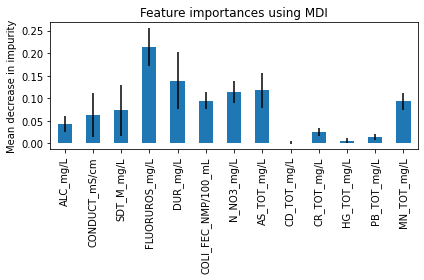

In [ ]:
# Feature importances
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"{i}" for i in X.columns]
forest = RandomForestClassifier(random_state=13)
forest.fit(X, y[["encoded"]])

import time

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(importances)
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

   FLUORUROS_mg/L  DUR_mg/L  COLI_FEC_NMP/100_mL  N_NO3_mg/L  AS_TOT_mg/L  \
0        1.022443  1.051107             1.000000    1.034422     1.013795   
1        1.021090  1.043541             1.000000    1.047361     1.007689   
2        1.046368  1.026570             1.000000    1.011818     1.061058   
3        1.026671  1.047453             1.000000    1.010237     1.012212   
4        1.000991  1.120555             1.011982    1.129370     1.000000   

   MN_TOT_mg/L  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0  


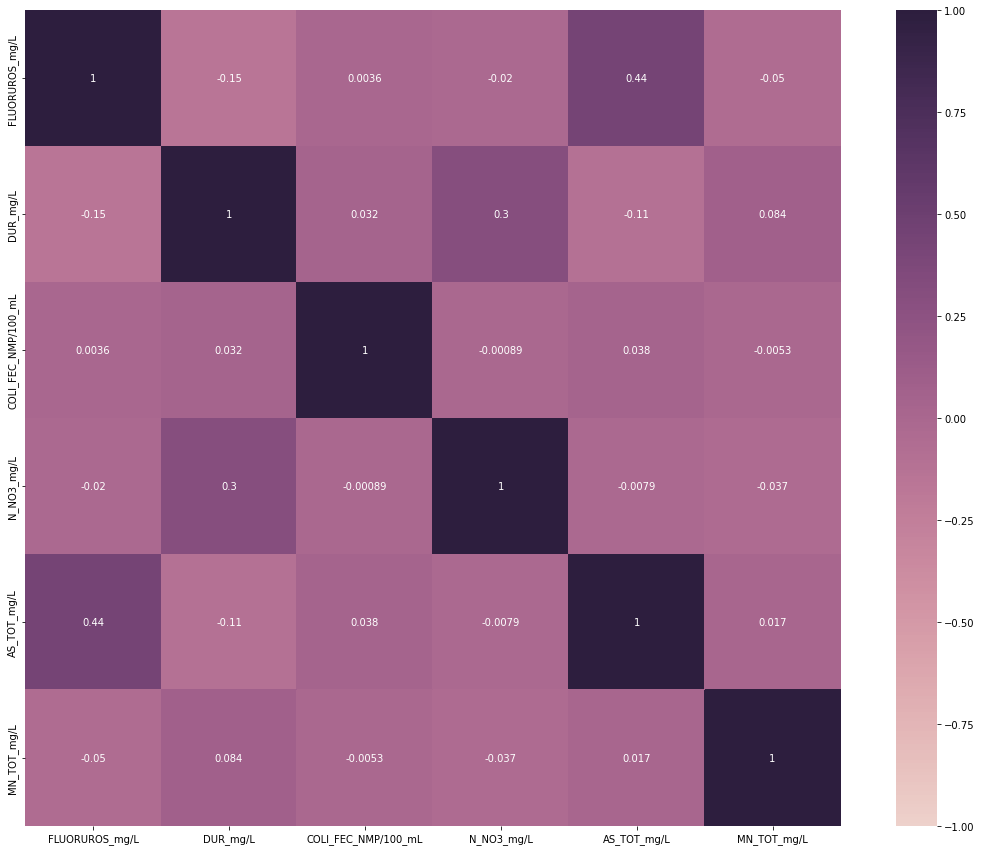

In [ ]:
# Seleccionar variables

X_select = X[[# 'ALC_mg/L',
              # 'CONDUCT_mS/cm', 
              # 'SDT_M_mg/L', 
              'FLUORUROS_mg/L', 
              'DUR_mg/L',
              'COLI_FEC_NMP/100_mL', 
              'N_NO3_mg/L', 
              'AS_TOT_mg/L', 
              # 'CD_TOT_mg/L',
              # 'CR_TOT_mg/L', 
              # 'HG_TOT_mg/L', 
              # 'PB_TOT_mg/L', 
              'MN_TOT_mg/L']]
print(X_select.head())
correlacion_X_sel = X_select.corr()
f, ax = plt.subplots(figsize = (20,15))
sns.heatmap(correlacion_X_sel, vmax = 1, vmin = -1, square = True, annot = True, cmap=sns.cubehelix_palette(as_cmap=True))

Al no haber una correlación alta entre las variables, se estima que random forest funcione mejor que decision tree.

In [ ]:
# Realizar clasificador

X_train, X_test, y_train, y_test = train_test_split(X_select, y[["encoded"]], test_size=0.20, random_state=13)

random_forest_classifier = RandomForestClassifier(random_state=13)
random_forest_classifier.fit(X_train, y_train)
y_pred_rf = random_forest_classifier.predict(X_test)

random_forest_cm = confusion_matrix(y_test, y_pred_rf)

decision_tree_classifier = DecisionTreeClassifier(random_state=13)
decision_tree_classifier.fit(X_train, y_train)
y_pred_dt = decision_tree_classifier.predict(X_test)

decision_tree_cm = confusion_matrix(y_test, y_pred_dt)

print(random_forest_cm)
print(decision_tree_cm)

[[81  7  1]
 [ 7 37  3]
 [ 2  2 74]]
[[75  6  8]
 [ 7 38  2]
 [ 2  5 71]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

   1 (green)       0.90      0.91      0.91        89
  2 (yellow)       0.80      0.79      0.80        47
     3 (red)       0.95      0.95      0.95        78

    accuracy                           0.90       214
   macro avg       0.88      0.88      0.88       214
weighted avg       0.90      0.90      0.90       214

Random Forest Confussion Matrix


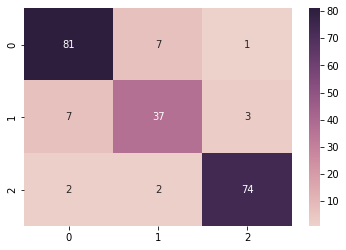

In [ ]:
target_names = ['1 (green)', '2 (yellow)', '3 (red)']
print(classification_report(y_test, y_pred_rf, target_names=target_names))

print("Random Forest Confussion Matrix")
htmp = sns.heatmap(random_forest_cm, annot = True, cmap=sns.cubehelix_palette(as_cmap=True))

              precision    recall  f1-score   support

   1 (green)       0.89      0.84      0.87        89
  2 (yellow)       0.78      0.81      0.79        47
     3 (red)       0.88      0.91      0.89        78

    accuracy                           0.86       214
   macro avg       0.85      0.85      0.85       214
weighted avg       0.86      0.86      0.86       214

Decision Tree Confussion Matrix


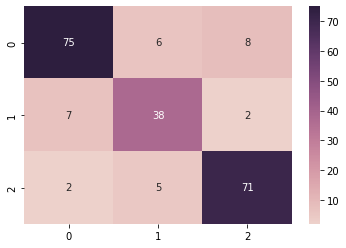

In [ ]:
target_names = ['1 (green)', '2 (yellow)', '3 (red)']
print(classification_report(y_test, y_pred_dt, target_names=target_names))

print("Decision Tree Confussion Matrix")
htmp = sns.heatmap(decision_tree_cm, annot = True, cmap=sns.cubehelix_palette(as_cmap=True))

Tal como se predijo, el modelo de Random Forest tuvo un mejor mejor rendimiento de clasificación, ya que al tener una baja correlación entre las variables, el modelo de decision tree puede sesgar la clasificación de las mismas.